<a href="https://colab.research.google.com/github/AbhiJeet70/GraphPoisoningCodes/blob/main/Meta_Airport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:0000:0100:01
Processing country: USA


Processing...
Done!


Statistics for USA:
  Number of nodes: 1190
  Number of edges: 13599
  Number of features: 1190
  Number of classes: 4
  Class distribution: [297 297 297 299]
Early stopping at epoch 106
Hidden Channels: 16, Learning Rate: 0.1, Weight Decay: 0.0001, Accuracy: 0.4435146443514644
Early stopping at epoch 105
Hidden Channels: 16, Learning Rate: 0.1, Weight Decay: 1e-05, Accuracy: 0.4560669456066946
Early stopping at epoch 126
Hidden Channels: 16, Learning Rate: 0.01, Weight Decay: 0.0001, Accuracy: 0.42677824267782427
Early stopping at epoch 128
Hidden Channels: 16, Learning Rate: 0.01, Weight Decay: 1e-05, Accuracy: 0.42677824267782427
Early stopping at epoch 408
Hidden Channels: 16, Learning Rate: 0.001, Weight Decay: 0.0001, Accuracy: 0.4435146443514644
Early stopping at epoch 337
Hidden Channels: 16, Learning Rate: 0.001, Weight Decay: 1e-05, Accuracy: 0.4435146443514644
Early stopping at epoch 105
Hidden Channels: 32, Learning Rate: 0.1, Weight Decay: 0.0001, Accuracy: 0.4225941422594

/tmp/ipykernel_33/2611898159.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Perturbation Percentage: 0.05, Accuracy: 0.4309623430962343
Perturbation Percentage: 0.1, Accuracy: 0.4435146443514644
Perturbation Percentage: 0.15, Accuracy: 0.4225941422594142
Perturbation Percentage: 0.2, Accuracy: 0.38493723849372385
Perturbation Percentage: 0.25, Accuracy: 0.41422594142259417
Processing country: Brazil


Processing...
Done!


Statistics for Brazil:
  Number of nodes: 131
  Number of edges: 1074
  Number of features: 131
  Number of classes: 4
  Class distribution: [32 32 32 35]
Early stopping at epoch 106
Hidden Channels: 16, Learning Rate: 0.1, Weight Decay: 0.0001, Accuracy: 0.48148148148148145
Early stopping at epoch 120
Hidden Channels: 16, Learning Rate: 0.1, Weight Decay: 1e-05, Accuracy: 0.3333333333333333
Early stopping at epoch 141
Hidden Channels: 16, Learning Rate: 0.01, Weight Decay: 0.0001, Accuracy: 0.4074074074074074
Early stopping at epoch 153
Hidden Channels: 16, Learning Rate: 0.01, Weight Decay: 1e-05, Accuracy: 0.4074074074074074
Early stopping at epoch 101
Hidden Channels: 16, Learning Rate: 0.001, Weight Decay: 0.0001, Accuracy: 0.2962962962962963
Early stopping at epoch 166
Hidden Channels: 16, Learning Rate: 0.001, Weight Decay: 1e-05, Accuracy: 0.37037037037037035
Early stopping at epoch 114
Hidden Channels: 32, Learning Rate: 0.1, Weight Decay: 0.0001, Accuracy: 0.4074074074074074


Processing...
Done!


Statistics for Europe:
  Number of nodes: 399
  Number of edges: 5995
  Number of features: 399
  Number of classes: 4
  Class distribution: [ 99  99  99 102]
Early stopping at epoch 103
Hidden Channels: 16, Learning Rate: 0.1, Weight Decay: 0.0001, Accuracy: 0.4625
Early stopping at epoch 105
Hidden Channels: 16, Learning Rate: 0.1, Weight Decay: 1e-05, Accuracy: 0.4625
Early stopping at epoch 102
Hidden Channels: 16, Learning Rate: 0.01, Weight Decay: 0.0001, Accuracy: 0.4375
Early stopping at epoch 285
Hidden Channels: 16, Learning Rate: 0.01, Weight Decay: 1e-05, Accuracy: 0.4375
Early stopping at epoch 101
Hidden Channels: 16, Learning Rate: 0.001, Weight Decay: 0.0001, Accuracy: 0.2625
Early stopping at epoch 113
Hidden Channels: 16, Learning Rate: 0.001, Weight Decay: 1e-05, Accuracy: 0.3
Early stopping at epoch 174
Hidden Channels: 32, Learning Rate: 0.1, Weight Decay: 0.0001, Accuracy: 0.45
Early stopping at epoch 105
Hidden Channels: 32, Learning Rate: 0.1, Weight Decay: 1e-0

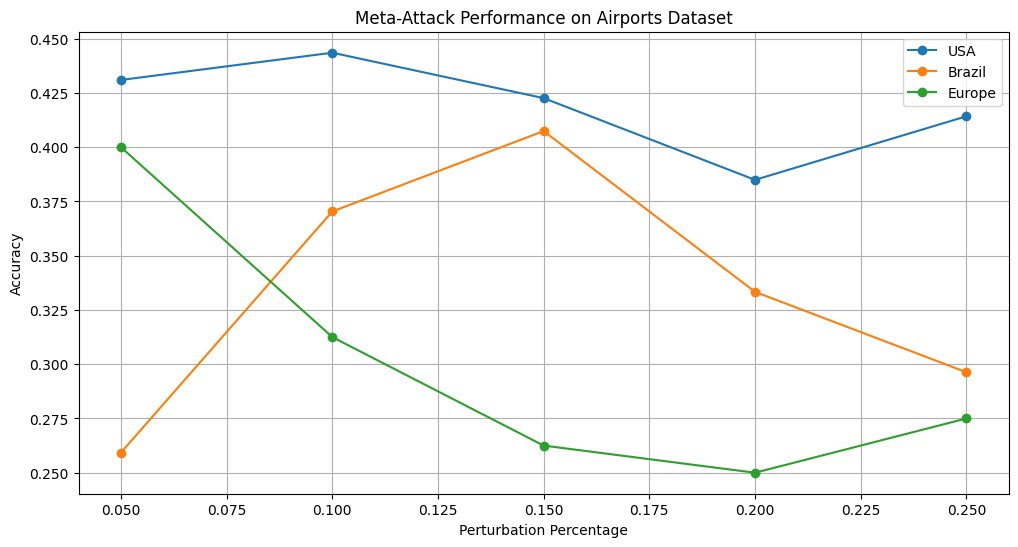

In [ ]:
# Install necessary packages
!pip install torch torch-geometric pandas matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import Airports
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(20)

# Define the GCN model
class GCNNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class MetaLearner(nn.Module):
    def __init__(self, model, features, adj, labels, idx_train, lambda_=0.5):
        super(MetaLearner, self).__init__()
        self.model = model
        self.features = features
        self.adj = adj
        self.labels = labels
        self.idx_train = idx_train
        self.lambda_ = lambda_
        self.adj_changes = nn.Parameter(torch.zeros_like(adj.to_dense().float()))  # Convert to float

    def forward(self, adj):
        adj = adj + self.adj_changes
        adj = torch.clamp(adj, 0, 1)
        return adj

    def loss(self, adj, output):
        return F.cross_entropy(output[self.idx_train], self.labels[self.idx_train])

def meta_attack(features, edge_index, labels, idx_train, idx_unlabeled, perturbations, lambda_=0.5, epochs=100):
    num_nodes = features.size(0)

    # Convert edge_index to dense adjacency matrix
    adj = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.size(1)), (num_nodes, num_nodes)).to_dense()

    # Initialize surrogate model
    in_channels = features.size(1)
    hidden_channels = 64
    out_channels = labels.max().item() + 1
    surrogate = GCNNet(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels)

    # Initialize meta-learner
    meta_learner = MetaLearner(model=surrogate, features=features, adj=adj, labels=labels, idx_train=idx_train, lambda_=lambda_)
    optimizer = torch.optim.Adam(meta_learner.parameters(), lr=0.01)

    # Perturb adjacency matrix
    for _ in range(perturbations):
        i = torch.randint(0, num_nodes, (1,))
        j = torch.randint(0, num_nodes, (1,))
        adj[i, j] = 1 - adj[i, j]
        adj[j, i] = adj[i, j]  # Ensure symmetry

    # Forward pass with surrogate model
    surrogate.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        perturbed_adj = meta_learner(adj)  # Apply meta-learner to get perturbed adjacency
        output = surrogate(features, edge_index)
        loss = meta_learner.loss(perturbed_adj, output)
        loss.backward()
        optimizer.step()

    # Return the perturbed adjacency matrix as edge_index
    edge_index_perturbed = perturbed_adj.nonzero(as_tuple=False).t().contiguous()
    return edge_index_perturbed

# Define function to load Airports data for a given country
def load_airports_data(country):
    dataset = Airports(root='/tmp/Airports', name=country, transform=NormalizeFeatures())
    data = dataset[0]
    return data

# Split data indices
def split_indices(num_nodes, train_ratio=0.7, val_ratio=0.1):
    indices = np.random.permutation(num_nodes)
    train_end = int(train_ratio * num_nodes)
    val_end = int((train_ratio + val_ratio) * num_nodes)
    return torch.tensor(indices[:train_end]), torch.tensor(indices[train_end:val_end]), torch.tensor(indices[val_end:])

# Train the model
def train_model(model, pyg_data, lr, weight_decay):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pyg_data = pyg_data.to(device)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0
    patience = 100
    patience_counter = 0

    for epoch in range(1, 501):
        model.train()
        optimizer.zero_grad()
        out = model(pyg_data.x, pyg_data.edge_index)
        loss = F.cross_entropy(out[pyg_data.train_mask], pyg_data.y[pyg_data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
        val_correct = float(pred[pyg_data.val_mask].eq(pyg_data.y[pyg_data.val_mask]).sum().item())
        val_acc = val_correct / pyg_data.val_mask.sum().item()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    model.load_state_dict(best_model_state)
    model.eval()
    _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
    correct = float(pred[pyg_data.test_mask].eq(pyg_data.y[pyg_data.test_mask]).sum().item())
    return correct / pyg_data.test_mask.sum().item()

# Define dataset statistics
def print_dataset_statistics(data, dataset_name):
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    num_features = data.num_node_features
    num_classes = data.y.max().item() + 1
    class_distribution = torch.bincount(data.y).cpu().numpy()
    print(f"Statistics for {dataset_name}:")
    print(f"  Number of nodes: {num_nodes}")
    print(f"  Number of edges: {num_edges}")
    print(f"  Number of features: {num_features}")
    print(f"  Number of classes: {num_classes}")
    print(f"  Class distribution: {class_distribution}")

def run_meta_attack_experiments(data, perturbation_percentage, model, best_hyperparams):
    train_idx = data.train_mask
    val_idx = data.val_mask

    perturbations = int(perturbation_percentage * data.edge_index.size(1))
    perturbed_data = data.clone()
    perturbed_edge_index = meta_attack(data.x, data.edge_index, data.y, train_idx, val_idx, perturbations)
    perturbed_data.edge_index = perturbed_edge_index

    # Ensure edge_index has valid indices
    valid_indices = (perturbed_data.edge_index[0] < perturbed_data.num_nodes) & (perturbed_data.edge_index[1] < perturbed_data.num_nodes)
    perturbed_data.edge_index = perturbed_data.edge_index[:, valid_indices]

    # Evaluate model on perturbed data
    model.eval()
    with torch.no_grad():
        logits = model(perturbed_data.x, perturbed_data.edge_index)
        pred = logits.argmax(dim=1)
        correct = (pred[perturbed_data.test_mask] == perturbed_data.y[perturbed_data.test_mask]).sum().item()
        acc = correct / perturbed_data.test_mask.sum().item()

    return acc

# Hyperparameter grid search
hidden_channels_list = [16, 32, 64, 128, 256, 512]  # Reduced for quicker testing
learning_rates = [0.1, 0.01, 0.001]  # Reduced for quicker testing
weight_decays = [1e-4, 1e-5]

# List of countries to process
countries = ['USA', 'Brazil', 'Europe']

# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Country', 'Hidden_Channels', 'Learning_Rate', 'Weight_Decay', 'Accuracy', 'Perturbation_Type', 'Perturbation_Percentage'])

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for country in countries:
    print(f'Processing country: {country}')
    data = load_airports_data(country)
    print_dataset_statistics(data, country)

    train_idx, val_idx, test_idx = split_indices(data.num_nodes)
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
    data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
    data.train_mask[train_idx] = True
    data.val_mask[val_idx] = True
    data.test_mask[test_idx] = True

    num_classes = data.y.max().item() + 1  # Calculate the number of classes

    best_accuracy = 0
    best_hyperparams = {'Hidden_Channels': None, 'Learning_Rate': None, 'Weight_Decay': None}

    for hidden_channels in hidden_channels_list:
        for lr in learning_rates:
            for wd in weight_decays:
                model = GCNNet(data.num_node_features, hidden_channels, num_classes)
                accuracy = train_model(model, data, lr, wd)
                print(f'Hidden Channels: {hidden_channels}, Learning Rate: {lr}, Weight Decay: {wd}, Accuracy: {accuracy}')

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_hyperparams = {'Hidden_Channels': hidden_channels, 'Learning_Rate': lr, 'Weight_Decay': wd}

    print(f'Best Hyperparameters for {country}: {best_hyperparams}, Accuracy: {best_accuracy}')

    # Run meta-attack experiments for different perturbation percentages
    perturbation_percentages = [0.05, 0.1, 0.15, 0.2, 0.25]
    perturbation_accuracies = []

    for perturbation_percentage in perturbation_percentages:
        acc = run_meta_attack_experiments(data, perturbation_percentage, model, best_hyperparams)
        perturbation_accuracies.append(acc)
        new_row = pd.DataFrame({
            'Country': [country],
            'Hidden_Channels': [best_hyperparams['Hidden_Channels']],
            'Learning_Rate': [best_hyperparams['Learning_Rate']],
            'Weight_Decay': [best_hyperparams['Weight_Decay']],
            'Accuracy': [acc],
            'Perturbation_Type': ['Meta'],
            'Perturbation_Percentage': [perturbation_percentage]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

        print(f'Perturbation Percentage: {perturbation_percentage}, Accuracy: {acc}')


# Save results to CSV
results_df.to_csv('meta_attack_results.csv', index=False)

print('Experiments completed and results saved to meta_attack_results.csv.')

# Plotting function
def plot_results(df, countries):
    plt.figure(figsize=(12, 6))
    for country in countries:
        country_data = df[df['Country'] == country]
        plt.plot(country_data['Perturbation_Percentage'], country_data['Accuracy'], marker='o', label=country)

    plt.xlabel('Perturbation Percentage')
    plt.ylabel('Accuracy')
    plt.title('Meta-Attack Performance on Airports Dataset')
    plt.legend()
    plt.grid(True)
    plt.show()

# Load results and plot
results_df = pd.read_csv('meta_attack_results.csv')
plot_results(results_df, countries)
